In [1]:
import pandas as pd
import MalekFinance as mf
import datetime as dt
from pandas.tseries.offsets import MonthEnd
from tqdm.notebook import tqdm
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
formation_dates = pd.date_range('1972-12-30','2022-11-30',freq='M')
returns_dates = pd.date_range('1973-1-31','2022-12-31',freq='M')
monthly_returns = mf.read('WRDS Data','All Exchanges CRSP PEMRMNO Monthly Returns DataFrame 63-22',index_col=0,parse_dates=True)
Returns_Check_NYSE_df = mf.read('WRDS Data','NYSE Monthly Returns',index_col=0,parse_dates=True)
monthly_size = mf.read('WRDS Data','All Exchanges CRSP PEMRMNO Monthly Size DataFrame 63-22',index_col=0,parse_dates=True)
NYSE_Size_df = monthly_size[monthly_size.columns.intersection(Returns_Check_NYSE_df.columns)]
past_48 = mf.past_x(monthly_returns,48)
NYSE_past_48 = mf.past_x(Returns_Check_NYSE_df,48)

In [3]:
SP = mf.spm()
ff = mf.fama_french_3_factor()
f5 = mf.fama_french_5_factor()
q4 = mf.q_factor_4()
q5 = mf.q_factor_5()

# Normal

In [4]:
def LTRF(formation):
    NYSE_Size = NYSE_Size_df.loc[formation].dropna()
    NYSE_Past_48 = NYSE_past_48.loc[formation - MonthEnd(12)].dropna()
    Returns_Check_NYSE = Returns_Check_NYSE_df.loc[formation + MonthEnd(1)].dropna()
    NYSE_Merged = pd.concat([Returns_Check_NYSE,NYSE_Past_48,NYSE_Size],axis=1).dropna()
    NYSE_Merged.columns = ['1 Month Forward Return','Past 48','Market Cap']
    Winners_Threshold = NYSE_Merged['Past 48'].quantile(0.3)
    Losers_Threshold = NYSE_Merged['Past 48'].quantile(0.7)
    Size_Breakpoint = NYSE_Merged['Market Cap'].median()
    All_Size = monthly_size.loc[formation ].dropna()
    All_Past_48 = past_48.loc[formation - MonthEnd(12)].dropna()
    All_Returns = monthly_returns.loc[formation + MonthEnd(1)].dropna()
    All_Merged = pd.concat([All_Returns,All_Past_48,All_Size],axis=1).dropna()
    All_Merged.columns = ['1 Month Forward Return','Past 48','Market Cap']
    Large = All_Merged[All_Merged['Market Cap'] >= Size_Breakpoint]
    Small = All_Merged[All_Merged['Market Cap'] <= Size_Breakpoint]
    Large_Winners = Large[Large['Past 48'] <= Winners_Threshold]
    Large_Losers = Large[Large['Past 48'] >= Losers_Threshold]
    Small_Winners = Small[Small['Past 48'] <= Winners_Threshold]
    Small_Losers = Small[Small['Past 48'] >= Losers_Threshold]
    Large_Winners_RET = sum(Large_Winners.iloc[:,0] * (Large_Winners.iloc[:,2]/sum(Large_Winners.iloc[:,2])))
    Large_Losers_RET = sum(Large_Losers.iloc[:,0] * (Large_Losers.iloc[:,2]/sum(Large_Losers.iloc[:,2])))
    Small_Winners_RET = sum(Small_Winners.iloc[:,0] * (Small_Winners.iloc[:,2]/sum(Small_Winners.iloc[:,2])))
    Small_Losers_RET = sum(Small_Losers.iloc[:,0] * (Small_Losers.iloc[:,2]/sum(Small_Losers.iloc[:,2])))
    Portfolio_Return = ((Large_Winners_RET + Small_Winners_RET) - (Large_Losers_RET + Small_Losers_RET))/2
    return Portfolio_Return

LTR = pd.DataFrame(data={'LTR':[LTRF(i) for i in formation_dates]},index=returns_dates)

# CAPM

In [5]:
def Residual_Reversal_CAPM(formation):
    NYSE_Size = NYSE_Size_df.loc[formation].dropna()
    Returns_Check_NYSE = Returns_Check_NYSE_df.loc[formation + MonthEnd(1)].dropna()
    NYSE_Past_48 = NYSE_past_48.loc[formation - MonthEnd(12)].dropna()
    NYSE_Merged = pd.concat([Returns_Check_NYSE,NYSE_Size,NYSE_Past_48],axis=1).dropna()
    NYSE_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    Size_Breakpoint = NYSE_Merged['Market Cap'].median()
    All_Size = monthly_size.loc[formation].dropna()
    All_Returns = monthly_returns.loc[formation + MonthEnd(1)].dropna()
    All_Past_48 = past_48.loc[formation - MonthEnd(12)].dropna()
    All_Merged = pd.concat([All_Returns,All_Size,All_Past_48],axis=1).dropna()
    All_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    df = monthly_returns[monthly_returns.columns.intersection(All_Merged.index)][formation - MonthEnd(59):formation].fillna(0)
    APM = SP[SP.index.isin(df.index)]
    x = sm.add_constant(APM)
    resids = mf.residuals(df,x)
    Past_LTR_Residual = mf.past_x(resids[formation - MonthEnd(59):formation - MonthEnd(12)],48).loc[formation - MonthEnd(12)]
    NYSE_Merged = NYSE_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    NYSE_Merged.rename(columns={NYSE_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Long_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.3)
    Short_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.7)
    All_Merged = All_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    All_Merged.rename(columns={All_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Large = All_Merged[All_Merged['Market Cap'] >= Size_Breakpoint]
    Small = All_Merged[All_Merged['Market Cap'] <= Size_Breakpoint]
    Large_Long = Large[Large['Residual Past 48 Month'] <= Long_Threshold]
    Large_Short = Large[Large['Residual Past 48 Month'] >= Short_Threshold]
    Small_Long = Small[Small['Residual Past 48 Month'] <= Long_Threshold]
    Small_Short = Small[Small['Residual Past 48 Month'] >= Short_Threshold]
    for i in Large_Long,Small_Long,Large_Short,Small_Short:
        i['Weight'] = i['Market Cap']/sum(i['Market Cap'])
    Large_Long_RET = sum(Large_Long['1 Month Forward Return'] * Large_Long['Weight'])
    Large_Short_RET = sum(Large_Short['1 Month Forward Return'] * Large_Short['Weight'])
    Small_Long_RET = sum(Small_Long['1 Month Forward Return'] * Small_Long['Weight'])
    Small_Short_RET = sum(Small_Short['1 Month Forward Return'] * Small_Short['Weight'])
    Portfolio_Return = ((Large_Long_RET + Small_Long_RET) - (Large_Short_RET + Small_Short_RET))/2
    return Portfolio_Return

Res_REV_CAPM = pd.DataFrame(data={'Residual Reversal CAPM':[Residual_Reversal_CAPM(i) for i in formation_dates]},index=returns_dates)

# FF3

In [6]:
def Residual_Reversal_FF3(formation):
    NYSE_Size = NYSE_Size_df.loc[formation].dropna()
    Returns_Check_NYSE = Returns_Check_NYSE_df.loc[formation + MonthEnd(1)].dropna()
    NYSE_Past_48 = NYSE_past_48.loc[formation - MonthEnd(12)].dropna()
    NYSE_Merged = pd.concat([Returns_Check_NYSE,NYSE_Size,NYSE_Past_48],axis=1).dropna()
    NYSE_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    Size_Breakpoint = NYSE_Merged['Market Cap'].median()
    All_Size = monthly_size.loc[formation].dropna()
    All_Returns = monthly_returns.loc[formation + MonthEnd(1)].dropna()
    All_Past_48 = past_48.loc[formation - MonthEnd(12)].dropna()
    All_Merged = pd.concat([All_Returns,All_Size,All_Past_48],axis=1).dropna()
    All_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    df = monthly_returns[monthly_returns.columns.intersection(All_Merged.index)][formation - MonthEnd(59):formation].fillna(0)
    APM = ff[ff.index.isin(df.index)]
    x = sm.add_constant(APM)
    resids = mf.residuals(df,x)
    Past_LTR_Residual = mf.past_x(resids[formation - MonthEnd(59):formation - MonthEnd(12)],48).loc[formation - MonthEnd(12)]
    NYSE_Merged = NYSE_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    NYSE_Merged.rename(columns={NYSE_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Long_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.3)
    Short_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.7)
    All_Merged = All_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    All_Merged.rename(columns={All_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Large = All_Merged[All_Merged['Market Cap'] >= Size_Breakpoint]
    Small = All_Merged[All_Merged['Market Cap'] <= Size_Breakpoint]
    Large_Long = Large[Large['Residual Past 48 Month'] <= Long_Threshold]
    Large_Short = Large[Large['Residual Past 48 Month'] >= Short_Threshold]
    Small_Long = Small[Small['Residual Past 48 Month'] <= Long_Threshold]
    Small_Short = Small[Small['Residual Past 48 Month'] >= Short_Threshold]
    for i in Large_Long,Small_Long,Large_Short,Small_Short:
        i['Weight'] = i['Market Cap']/sum(i['Market Cap'])
    Large_Long_RET = sum(Large_Long['1 Month Forward Return'] * Large_Long['Weight'])
    Large_Short_RET = sum(Large_Short['1 Month Forward Return'] * Large_Short['Weight'])
    Small_Long_RET = sum(Small_Long['1 Month Forward Return'] * Small_Long['Weight'])
    Small_Short_RET = sum(Small_Short['1 Month Forward Return'] * Small_Short['Weight'])
    Portfolio_Return = ((Large_Long_RET + Small_Long_RET) - (Large_Short_RET + Small_Short_RET))/2
    return Portfolio_Return

Res_REV_FF3 = pd.DataFrame(data={'Residual Reversal FF3':[Residual_Reversal_FF3(i) for i in formation_dates]},index=returns_dates)

# FF5

In [7]:
def Residual_Reversal_FF5(formation):
    NYSE_Size = NYSE_Size_df.loc[formation].dropna()
    Returns_Check_NYSE = Returns_Check_NYSE_df.loc[formation + MonthEnd(1)].dropna()
    NYSE_Past_48 = NYSE_past_48.loc[formation - MonthEnd(12)].dropna()
    NYSE_Merged = pd.concat([Returns_Check_NYSE,NYSE_Size,NYSE_Past_48],axis=1).dropna()
    NYSE_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    Size_Breakpoint = NYSE_Merged['Market Cap'].median()
    All_Size = monthly_size.loc[formation].dropna()
    All_Returns = monthly_returns.loc[formation + MonthEnd(1)].dropna()
    All_Past_48 = past_48.loc[formation - MonthEnd(12)].dropna()
    All_Merged = pd.concat([All_Returns,All_Size,All_Past_48],axis=1).dropna()
    All_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    df = monthly_returns[monthly_returns.columns.intersection(All_Merged.index)][formation - MonthEnd(59):formation].fillna(0)
    APM = f5[f5.index.isin(df.index)]
    x = sm.add_constant(APM)
    resids = mf.residuals(df,x)
    Past_LTR_Residual = mf.past_x(resids[formation - MonthEnd(59):formation - MonthEnd(12)],48).loc[formation - MonthEnd(12)]
    NYSE_Merged = NYSE_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    NYSE_Merged.rename(columns={NYSE_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Long_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.3)
    Short_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.7)
    All_Merged = All_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    All_Merged.rename(columns={All_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Large = All_Merged[All_Merged['Market Cap'] >= Size_Breakpoint]
    Small = All_Merged[All_Merged['Market Cap'] <= Size_Breakpoint]
    Large_Long = Large[Large['Residual Past 48 Month'] <= Long_Threshold]
    Large_Short = Large[Large['Residual Past 48 Month'] >= Short_Threshold]
    Small_Long = Small[Small['Residual Past 48 Month'] <= Long_Threshold]
    Small_Short = Small[Small['Residual Past 48 Month'] >= Short_Threshold]
    for i in Large_Long,Small_Long,Large_Short,Small_Short:
        i['Weight'] = i['Market Cap']/sum(i['Market Cap'])
    Large_Long_RET = sum(Large_Long['1 Month Forward Return'] * Large_Long['Weight'])
    Large_Short_RET = sum(Large_Short['1 Month Forward Return'] * Large_Short['Weight'])
    Small_Long_RET = sum(Small_Long['1 Month Forward Return'] * Small_Long['Weight'])
    Small_Short_RET = sum(Small_Short['1 Month Forward Return'] * Small_Short['Weight'])
    Portfolio_Return = ((Large_Long_RET + Small_Long_RET) - (Large_Short_RET + Small_Short_RET))/2
    return Portfolio_Return

Res_REV_FF5 = pd.DataFrame(data={'Residual Reversal FF5':[Residual_Reversal_FF5(i) for i in formation_dates]},index=returns_dates)

# q4

In [8]:
def Residual_Reversal_q4(formation):
    NYSE_Size = NYSE_Size_df.loc[formation].dropna()
    Returns_Check_NYSE = Returns_Check_NYSE_df.loc[formation + MonthEnd(1)].dropna()
    NYSE_Past_48 = NYSE_past_48.loc[formation - MonthEnd(12)].dropna()
    NYSE_Merged = pd.concat([Returns_Check_NYSE,NYSE_Size,NYSE_Past_48],axis=1).dropna()
    NYSE_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    Size_Breakpoint = NYSE_Merged['Market Cap'].median()
    All_Size = monthly_size.loc[formation].dropna()
    All_Returns = monthly_returns.loc[formation + MonthEnd(1)].dropna()
    All_Past_48 = past_48.loc[formation - MonthEnd(12)].dropna()
    All_Merged = pd.concat([All_Returns,All_Size,All_Past_48],axis=1).dropna()
    All_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    df = monthly_returns[monthly_returns.columns.intersection(All_Merged.index)][formation - MonthEnd(59):formation].fillna(0)
    APM = q4[q4.index.isin(df.index)]
    x = sm.add_constant(APM)
    resids = mf.residuals(df,x)
    Past_LTR_Residual = mf.past_x(resids[formation - MonthEnd(59):formation - MonthEnd(12)],48).loc[formation - MonthEnd(12)]
    NYSE_Merged = NYSE_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    NYSE_Merged.rename(columns={NYSE_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Long_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.3)
    Short_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.7)
    All_Merged = All_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    All_Merged.rename(columns={All_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Large = All_Merged[All_Merged['Market Cap'] >= Size_Breakpoint]
    Small = All_Merged[All_Merged['Market Cap'] <= Size_Breakpoint]
    Large_Long = Large[Large['Residual Past 48 Month'] <= Long_Threshold]
    Large_Short = Large[Large['Residual Past 48 Month'] >= Short_Threshold]
    Small_Long = Small[Small['Residual Past 48 Month'] <= Long_Threshold]
    Small_Short = Small[Small['Residual Past 48 Month'] >= Short_Threshold]
    for i in Large_Long,Small_Long,Large_Short,Small_Short:
        i['Weight'] = i['Market Cap']/sum(i['Market Cap'])
    Large_Long_RET = sum(Large_Long['1 Month Forward Return'] * Large_Long['Weight'])
    Large_Short_RET = sum(Large_Short['1 Month Forward Return'] * Large_Short['Weight'])
    Small_Long_RET = sum(Small_Long['1 Month Forward Return'] * Small_Long['Weight'])
    Small_Short_RET = sum(Small_Short['1 Month Forward Return'] * Small_Short['Weight'])
    Portfolio_Return = ((Large_Long_RET + Small_Long_RET) - (Large_Short_RET + Small_Short_RET))/2
    return Portfolio_Return

Res_REV_q4 = pd.DataFrame(data={'Residual Reversal q4':[Residual_Reversal_q4(i) for i in formation_dates]},index=returns_dates)

# q5

In [9]:
def Residual_Reversal_q5(formation):
    NYSE_Size = NYSE_Size_df.loc[formation].dropna()
    Returns_Check_NYSE = Returns_Check_NYSE_df.loc[formation + MonthEnd(1)].dropna()
    NYSE_Past_48 = NYSE_past_48.loc[formation - MonthEnd(12)].dropna()
    NYSE_Merged = pd.concat([Returns_Check_NYSE,NYSE_Size,NYSE_Past_48],axis=1).dropna()
    NYSE_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    Size_Breakpoint = NYSE_Merged['Market Cap'].median()
    All_Size = monthly_size.loc[formation].dropna()
    All_Returns = monthly_returns.loc[formation + MonthEnd(1)].dropna()
    All_Past_48 = past_48.loc[formation - MonthEnd(12)].dropna()
    All_Merged = pd.concat([All_Returns,All_Size,All_Past_48],axis=1).dropna()
    All_Merged.columns = ['1 Month Forward Return','Market Cap','Past 48']
    df = monthly_returns[monthly_returns.columns.intersection(All_Merged.index)][formation - MonthEnd(59):formation].fillna(0)
    APM = q5[q5.index.isin(df.index)]
    x = sm.add_constant(APM)
    resids = mf.residuals(df,x)
    Past_LTR_Residual = mf.past_x(resids[formation - MonthEnd(59):formation - MonthEnd(12)],48).loc[formation - MonthEnd(12)]
    NYSE_Merged = NYSE_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    NYSE_Merged.rename(columns={NYSE_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Long_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.3)
    Short_Threshold = NYSE_Merged['Residual Past 48 Month'].quantile(0.7)
    All_Merged = All_Merged.merge(Past_LTR_Residual,left_index=True,right_index=True,how='inner').dropna()
    All_Merged.rename(columns={All_Merged.columns[3]:'Residual Past 48 Month'},inplace=True)
    Large = All_Merged[All_Merged['Market Cap'] >= Size_Breakpoint]
    Small = All_Merged[All_Merged['Market Cap'] <= Size_Breakpoint]
    Large_Long = Large[Large['Residual Past 48 Month'] <= Long_Threshold]
    Large_Short = Large[Large['Residual Past 48 Month'] >= Short_Threshold]
    Small_Long = Small[Small['Residual Past 48 Month'] <= Long_Threshold]
    Small_Short = Small[Small['Residual Past 48 Month'] >= Short_Threshold]
    for i in Large_Long,Small_Long,Large_Short,Small_Short:
        i['Weight'] = i['Market Cap']/sum(i['Market Cap'])
    Large_Long_RET = sum(Large_Long['1 Month Forward Return'] * Large_Long['Weight'])
    Large_Short_RET = sum(Large_Short['1 Month Forward Return'] * Large_Short['Weight'])
    Small_Long_RET = sum(Small_Long['1 Month Forward Return'] * Small_Long['Weight'])
    Small_Short_RET = sum(Small_Short['1 Month Forward Return'] * Small_Short['Weight'])
    Portfolio_Return = ((Large_Long_RET + Small_Long_RET) - (Large_Short_RET + Small_Short_RET))/2
    return Portfolio_Return

Res_REV_q5 = pd.DataFrame(data={'Residual Reversal q5':[Residual_Reversal_q5(i) for i in formation_dates]},index=returns_dates)

In [10]:
mf.summary(LTR)

Annual Return: 2.80%
Annual Volity: 9.27%
Sharpe Ratio: 0.30
Max Drawdown: -55.0%


In [11]:
mf.summary(Res_REV_CAPM)

Annual Return: 3.71%
Annual Volity: 11.42%
Sharpe Ratio: 0.32
Max Drawdown: -45.8%


In [12]:
mf.summary(Res_REV_FF3)

Annual Return: 2.72%
Annual Volity: 9.95%
Sharpe Ratio: 0.27
Max Drawdown: -44.5%


In [13]:
mf.summary(Res_REV_FF5)

Annual Return: 2.86%
Annual Volity: 10.03%
Sharpe Ratio: 0.29
Max Drawdown: -49.7%


In [14]:
mf.summary(Res_REV_q4)

Annual Return: 3.94%
Annual Volity: 10.10%
Sharpe Ratio: 0.39
Max Drawdown: -33.7%


In [15]:
mf.summary(Res_REV_q5)

Annual Return: 4.36%
Annual Volity: 9.93%
Sharpe Ratio: 0.44
Max Drawdown: -29.6%


In [16]:
pd.concat([LTR,Res_REV_CAPM,Res_REV_FF3,Res_REV_FF5,Res_REV_q4,Res_REV_q5],axis=1).dropna().corr()

,LTR,Residual Reversal CAPM,Residual Reversal FF3,Residual Reversal FF5,Residual Reversal q4,Residual Reversal q5
LTR,1.0000,0.1571,0.0466,0.0319,0.0864,0.0849
Residual Reversal CAPM,0.1571,1.0000,0.9094,0.8981,0.9328,0.9306
Residual Reversal FF3,0.0466,0.9094,1.0000,0.9688,0.9384,0.9351
Residual Reversal FF5,0.0319,0.8981,0.9688,1.0000,0.9338,0.9288
Residual Reversal q4,0.0864,0.9328,0.9384,0.9338,1.0000,0.9870
Residual Reversal q5,0.0849,0.9306,0.9351,0.9288,0.9870,1.0000


In [17]:
mf.summary_df(pd.concat([LTR,Res_REV_CAPM,Res_REV_FF3,Res_REV_FF5,Res_REV_q4,Res_REV_q5],axis=1).dropna())

,LTR,Residual Reversal CAPM,Residual Reversal FF3,Residual Reversal FF5,Residual Reversal q4,Residual Reversal q5
Annual Return,2.8000,3.7100,2.7200,2.8600,3.9400,4.3600
Annual Volity,9.2700,11.4200,9.9500,10.0300,10.1000,9.9300
Sharpe Ratio,0.3000,0.3200,0.2700,0.2900,0.3900,0.4400
Max Drawdown,-55.0200,-45.8100,-44.4600,-49.6700,-33.7300,-29.5800
Portfolio Beta,0.0000,0.1700,0.1600,0.1900,0.1400,0.1500


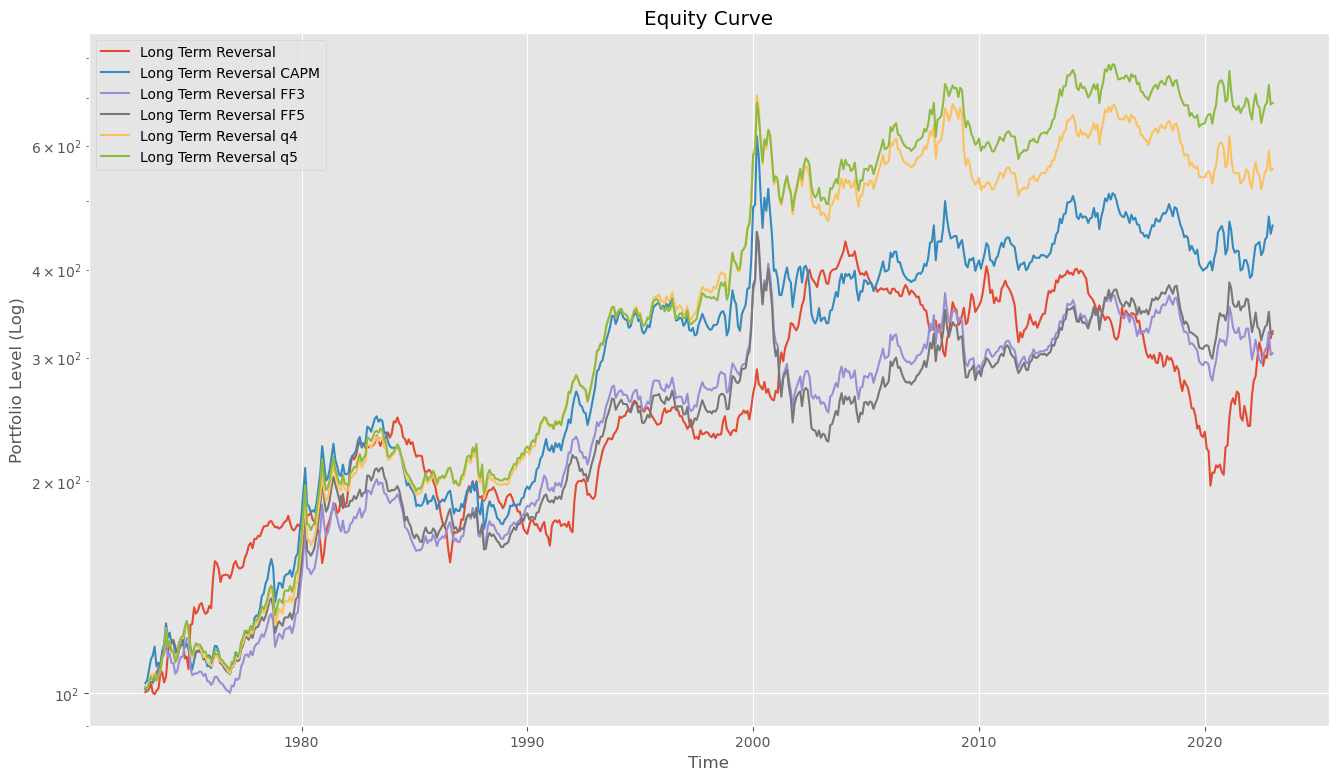

In [18]:
plt.figure(figsize=(16,9))
plt.plot(LTR.index,100*(1+LTR).cumprod(),label='Long Term Reversal')
plt.plot(LTR.index,100*(1+Res_REV_CAPM).cumprod(),label='Long Term Reversal CAPM')
plt.plot(LTR.index,100*(1+Res_REV_FF3).cumprod(),label='Long Term Reversal FF3')
plt.plot(LTR.index,100*(1+Res_REV_FF5).cumprod(),label='Long Term Reversal FF5')
plt.plot(LTR.index,100*(1+Res_REV_q4).cumprod(),label='Long Term Reversal q4')
plt.plot(LTR.index,100*(1+Res_REV_q5).cumprod(),label='Long Term Reversal q5')
plt.yscale('log')
plt.legend()
plt.ylabel('Portfolio Level (Log)')
plt.xlabel('Time')
plt.title('Equity Curve')
plt.show()